In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from os.path import join
import sys
sys.path.append("../")
sys.path.append("../model")

## 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns

## encoding 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

## vocabulary
import tensorflow_datasets as tfds

## tokenizer 
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

## preprocessor
from custom_preprocessor import Preprocessor

## model
from transformer_v1 import transformer

from tensorflow.keras import backend as K

# hyper parameter

In [21]:
# 토크나이저 파라미터
VOCAB_SIZE = 10000

# 학습 파라미터
EPOCHS = 1

# 모델 구조 파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

# Data 준비

In [22]:
preprocessor = Preprocessor()
preprocessed_train, preprocessed_test = preprocessor.preprocess()

In [23]:
preprocessed_train["conversation"].apply(lambda x: len(x.split())).max()

## CLASS_NAMES에 '일반 대화'를 포함시킴
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 수동 매핑 설정
class_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}


# 'class' 열을 수동 매핑 적용하기 전에 문자열로 변환
preprocessed_train['class'] = preprocessed_train['class'].astype(str).map(class_mapping)
labels = preprocessed_train['class']

In [24]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# 특수 토큰 ID 확인
CLS_TOKEN_ID = tokenizer.cls_token_id  # [CLS] 토큰 ID
SEP_TOKEN_ID = tokenizer.sep_token_id  # [SEP] 토큰 ID
UNK_TOKEN_ID = tokenizer.unk_token_id  # [UNK] 토큰 ID
PAD_TOKEN_ID = tokenizer.pad_token_id  # [PAD] 토큰 ID

# 각 문장에 [CLS], [SEP] 추가
def add_special_tokens(tokenized_texts):
    return [[CLS_TOKEN_ID] + tokenizer.convert_tokens_to_ids(tokens) + [SEP_TOKEN_ID] for tokens in tokenized_texts]

## 토크나이징
tokenized_train = [tokenizer.tokenize(con) for con in preprocessed_train['conversation'].tolist()]
tokenized_test = [tokenizer.tokenize(con) for con in preprocessed_test['text'].tolist()]

## [CLS], [SEP] 토큰 추가
token_id_train = add_special_tokens(tokenized_train)
token_id_test = add_special_tokens(tokenized_test)

# 패딩과 트렁케이션 설정
## 문장의 max length를 test 문장의 최대 길이로 설정한다. 
## padding은 앞에서부터 진행
## max길이를 넘어가면 앞에서부터 자른다. -> 한국말은 끝까지 들어야하므로..
token_id_train = pad_sequences(token_id_train, maxlen=191, dtype='long', padding='pre', truncating='pre', value=PAD_TOKEN_ID)
token_id_test = pad_sequences(token_id_test, maxlen=191, dtype='long', padding='pre', truncating='pre', value=PAD_TOKEN_ID)

In [25]:
token_id_train.shape

(4976, 191)

In [26]:
test_size_rate = 0.2
val_size_rate = 0.1

BATCH_SIZE = 64
BUFFER_SIZE = 10000


# 시드값 설정
seed = 1004
X_train, X_test, y_train, y_test = train_test_split(token_id_train, labels, test_size=test_size_rate, stratify=labels, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size_rate, stratify=y_train, random_state=seed)

# 클래스 가중치 계산 (클래스 4 포함)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 각 샘플에 가중치 할당
sample_weights = np.array([class_weights[y] for y in y_train])

# tf.data.Dataset으로 변환 (sample_weight 포함)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# 데이터셋을 섞고, 배치 처리
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Model 설정

In [27]:
# 하이퍼파라미터
VOCAB_SIZE = 1000
NUM_LAYERS = 1 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    783104      inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 256)          0           encoder[0][0]          

In [28]:
# y_train
y_true_classes = tf.argmax(y_train, axis=-1)
y_train.shape

(3582,)

In [29]:
def loss_function(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False)(y_true, y_pred)
    return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

def recall_m(y_true, y_pred):

    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5),K.floatx())
    true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.clip(y_true, 0, 1))
    recall_ratio = true_positives / (possible_positives + K.epsilon())
    return recall_ratio

def precision_m(y_true, y_pred):

    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), 0.5), K.floatx())
    true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(y_pred)
    precision_ratio = true_positives / (predicted_positives + K.epsilon())
    return precision_ratio

def f1_m(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[f1_m])

# 학습

In [32]:
EPOCHS = 100
history = model.fit(
    train_dataset,
    validation_data=val_dataset,  # 검증 데이터셋 추가
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/100
56/56 [==============================] - 4s 43ms/step - loss: 1.7043 - f1_m: 0.0309 - val_loss: 1.6069 - val_f1_m: 0.0000e+00
Epoch 2/100
56/56 [==============================] - 2s 36ms/step - loss: 1.6084 - f1_m: 0.0000e+00 - val_loss: 1.5794 - val_f1_m: 0.0000e+00
Epoch 3/100
56/56 [==============================] - 2s 36ms/step - loss: 1.5924 - f1_m: 0.0000e+00 - val_loss: 1.5713 - val_f1_m: 0.0000e+00
Epoch 4/100
56/56 [==============================] - 2s 36ms/step - loss: 1.5751 - f1_m: 6.4935e-04 - val_loss: 1.5540 - val_f1_m: 0.0000e+00
Epoch 5/100
56/56 [==============================] - 2s 36ms/step - loss: 1.5487 - f1_m: 6.8681e-04 - val_loss: 1.5209 - val_f1_m: 0.0000e+00
Epoch 6/100
56/56 [==============================] - 2s 36ms/step - loss: 1.5007 - f1_m: 0.1078 - val_loss: 1.4844 - val_f1_m: 0.3501
Epoch 7/100
56/56 [==============================] - 2s 36ms/step - loss: 1.4842 - f1_m: 0.2614 - val_loss: 1.4652 - val_f1_m: 0.3734
Epoch 8/100
56/56 [=======

56/56 [==============================] - 2s 36ms/step - loss: 0.8905 - f1_m: 0.6899 - val_loss: 2.2305 - val_f1_m: 0.6874
Epoch 62/100
56/56 [==============================] - 2s 36ms/step - loss: 0.8606 - f1_m: 0.6952 - val_loss: 2.3363 - val_f1_m: 0.7103
Epoch 63/100
56/56 [==============================] - 2s 36ms/step - loss: 0.8463 - f1_m: 0.7158 - val_loss: 2.1532 - val_f1_m: 0.7106
Epoch 64/100
56/56 [==============================] - 2s 36ms/step - loss: 0.8594 - f1_m: 0.7035 - val_loss: 2.3388 - val_f1_m: 0.6941
Epoch 65/100
56/56 [==============================] - 2s 36ms/step - loss: 0.8369 - f1_m: 0.7170 - val_loss: 2.2838 - val_f1_m: 0.6686
Epoch 66/100
56/56 [==============================] - 2s 36ms/step - loss: 0.8437 - f1_m: 0.7239 - val_loss: 2.4626 - val_f1_m: 0.6902
Epoch 67/100
56/56 [==============================] - 2s 36ms/step - loss: 0.8345 - f1_m: 0.7061 - val_loss: 2.4557 - val_f1_m: 0.7095
Epoch 68/100
56/56 [==============================] - 2s 37ms/step -

KeyError: 'accuracy'

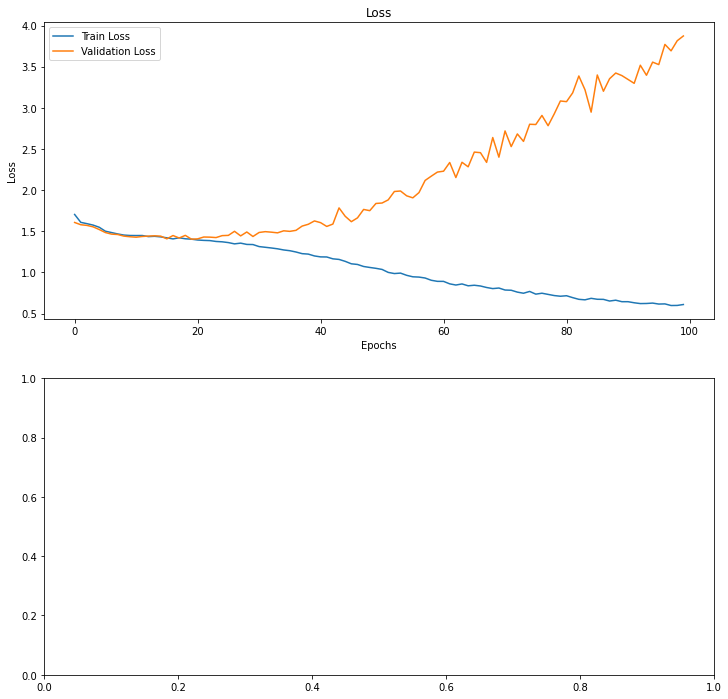

In [33]:
import matplotlib.pyplot as plt

# 정확한 val_loss 및 val_accuracy 플롯
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Train/Val Loss Plot
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Train/Val Accuracy Plot
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [ ]:
model.evaluate(test_dataset)

# submission

In [17]:
result_vec = model(token_id_test)
y_pred = np.argmax(result_vec, axis=1)
result_vec

<tf.Tensor: shape=(500, 191, 5), dtype=float32, numpy=
array([[[0.07462311, 0.27142942, 0.1644023 , 0.19443707, 0.29510805],
        [0.06907566, 0.26791865, 0.14656192, 0.190807  , 0.32563674],
        [0.06747376, 0.25854054, 0.14847824, 0.16164742, 0.36386   ],
        ...,
        [0.06300951, 0.23871227, 0.1727236 , 0.27418628, 0.25136834],
        [0.06870203, 0.25722283, 0.16875002, 0.29451165, 0.21081343],
        [0.07852988, 0.25822982, 0.15542494, 0.34263477, 0.16518068]],

       [[0.07405151, 0.27174923, 0.16547611, 0.19197367, 0.29674947],
        [0.06877737, 0.26818573, 0.14824331, 0.18791781, 0.32687578],
        [0.06752957, 0.2592174 , 0.14944693, 0.15920675, 0.36459935],
        ...,
        [0.06373075, 0.23828508, 0.17290445, 0.27175993, 0.25331974],
        [0.06928586, 0.25674498, 0.16935652, 0.2932962 , 0.21131645],
        [0.07901414, 0.26161507, 0.15457311, 0.33796442, 0.16683318]],

       [[0.09234335, 0.30044898, 0.21089227, 0.14569591, 0.25061947],
     

In [19]:
result_vec = model.predict(token_id_test)
result_vec

array([[[0.0746231 , 0.27142945, 0.16440229, 0.19443707, 0.29510808],
        [0.06907567, 0.2679185 , 0.14656198, 0.19080707, 0.32563677],
        [0.06747375, 0.25854054, 0.14847831, 0.16164745, 0.36385992],
        ...,
        [0.06300946, 0.23871218, 0.17272362, 0.27418637, 0.25136837],
        [0.06870206, 0.25722283, 0.16874997, 0.29451174, 0.2108134 ],
        [0.07852983, 0.25822976, 0.15542486, 0.34263486, 0.16518071]],

       [[0.07405146, 0.27174923, 0.16547608, 0.19197372, 0.29674944],
        [0.06877735, 0.26818568, 0.14824334, 0.18791787, 0.32687578],
        [0.06752957, 0.25921738, 0.14944685, 0.15920672, 0.36459947],
        ...,
        [0.06373075, 0.23828506, 0.17290448, 0.27176002, 0.25331968],
        [0.06928586, 0.25674498, 0.16935657, 0.2932962 , 0.21131647],
        [0.07901417, 0.2616151 , 0.15457314, 0.33796436, 0.16683318]],

       [[0.09234336, 0.30044898, 0.2108922 , 0.1456959 , 0.25061956],
        [0.09181117, 0.28710964, 0.19276223, 0.1552712 , 0.2

In [15]:
y_pred.shape

(500, 5)

In [16]:
def save_submission(y_pred, user_name, f1_score=None):
    data_path ="/aiffel/aiffel/dlthon_team5/data"
    save_path ="/aiffel/aiffel/dlthon_team5/submission"
    submission_path = join(data_path, 'new_submission.csv')
    submission = pd.read_csv(submission_path)
    submission.columns = ['idx', 'target']
    submission['target'] = y_pred
    submission_csv_path = '{}/submission_{}_f1score_{}.csv'.format(save_path, user_name, f1_score)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(y_pred,'phc_v1','75')